In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
import time
import os
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

C:\Users\m1824\AppData\Local\Temp\ipykernel_4448\1984699101.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
path = os.path.join(os.path.abspath(''),'netflix_titles.csv')
df = pd.read_csv(path)

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
class RecData():
    def __init__(self,k = 200):
        self.path = os.path.join(os.path.abspath(''),'netflix_titles.csv')
        self.data = pd.read_csv(self.path)
        
        self.columns = self.data.columns
        self.vector = TfidfVectorizer(max_df = 0.5,
                                     min_df = 1,
                                     stop_words = 'english',
                                     lowercase = True,
                                     use_idf = True,
                                     norm = u'l2',
                                     smooth_idf = True)
        self.G = nx.Graph(label = 'MOVIE')
        self.k = k
    def data_describe(self):
        return self.data.info()
    def process_data(self):
        self.data['date_added'] = pd.to_datetime(self.data['date_added'])
        self.data['year'] = self.data['date_added'].dt.year
        self.data['month'] = self.data['date_added'].dt.month
        self.data['day'] = self.data['date_added'].dt.day
        
        self.data['directors'] = self.data['director'].apply(lambda d:[] if pd.isna(d) else [i.strip() for i in d.split(',')])
        self.data['categories'] = self.data['listed_in'].apply(lambda c:[] if pd.isna(c) else [i.strip() for i in c.split(',')])
        self.data['actors'] = self.data['cast'].apply(lambda a:[] if pd.isna(a) else [i.strip() for i in a.strip(',')])
        self.data['countries'] = self.data['country'].apply(lambda c:[] if pd.isna(c) else [i.strip() for i in c.split(',')])
    def kmeans_base_tfidf(self):
        text_content = self.data['description']
        self.tfidf = self.vector.fit_transform(text_content)
        kmeans = MiniBatchKMeans(n_clusters = self.k)
        kmeans.fit(self.tfidf)
        centers = kmeans.cluster_centers_.argsort()[:,::-1]
        terms = self.vector.get_feature_names_out()
        
        request_transform = self.vector.transform(self.data['description'])
        
        self.data['cluster'] = kmeans.predict(request_transform)
        cluster_info = self.data['cluster'].value_counts()
        return cluster_info.reset_index()
    def count_similar(self,tfidf_matrix,index,top_n = 6):
        cosine_similarities = linear_kernel(tfidf_matrix[index:index+1],tfidf_matrix).flatten()
        related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
        return [index for index in related_docs_indices][:top_n]
    def build_graph_node(self):
        start_time = time.time()
        for i,rowi in self.data.iterrows():
            if (i % 1000 == 0):
                print('iter {}--{} seconds--'.format(i,time.time() -start_time))
            self.G.add_node(rowi['title'],key = rowi['show_id'],label = 'MOVIE',mtype = rowi['type'],rating = rowi['rating'])
            for element in rowi['actors']:
                self.G.add_node(element,label = 'PERSON')
                self.G.add_edge(rowi['title'],element,label = 'ACTED_IN')
            for element in rowi['categories']:
                self.G.add_node(element,label = 'CAT')
                self.G.add_edge(rowi['title'],element,label = 'CAT_IN')
            for element in rowi['directors']:
                self.G.add_node(element,label = 'PERSON')
                self.G.add_edge(rowi['title'],element,label = 'DIRECTED')
            for element in rowi['countries']:
                self.G.add_node(element,label = 'COU')
                self.G.add_edge(rowi['title'],element,label = 'COU_IN')
            indices = self.count_similar(self.tfidf,i,top_n = 6)
            snode = 'Sim(' + rowi['title'][:15].strip() + ')'
            self.G.add_node(snode,label = 'SIMILAR')
            self.G.add_edge(rowi['title'],snode,label = 'SIMILARITY')
            for element in indices:
                self.G.add_edge(snode,self.data['title'].loc[element],label = 'SIMILARITY')
        print('finsh -- {} seconds --'.format(time.time() - start_time))
    def get_all_graph_node(self,list_in):
        sub_graph = set()
        for m in list_in:
            sub_graph.add(m)
            for e in self.G.neighbors(m):
                sub_graph.add(e)
        return list(sub_graph)
    def draw_sub_graph(self,sub_graph):
        subgraph = self.G.subgraph(sub_graph)
        colors = []
        
        for e in subgraph.nodes():
            if self.G.nodes[e]['label'] == 'MOVIE':
                colors.append('blue')
            elif self.G.nodes[e]['label'] == 'PERSON':
                colors.append('red')
            elif self.G.nodes[e]['label'] == 'CAT':
                colors.append('green')
            elif self.G.nodes[e]['label'] == 'COU':
                colors.append('yellow')
            elif self.G.nodes[e]['label'] == 'SIMILAR':
                colors.append('orange')
            elif self.G.nodes[e]['label'] == 'CLUSTER':
                colors.append('black')
        nx.draw(subgraph,with_labels = True,font_weight = 'bold',node_color = colors)
        plt.show()
    def get_recommendation(self,root):
        commons_dict = {}
        for e in self.G.neighbors(root):
            for e2 in self.G.neighbors(e):
                if e2 == root:
                    continue
                if self.G.nodes[e2]['label'] == 'MOVIE':
                    commons = commons_dict.get(e2)
                    if commons == None:
                        commons_dict.update({e2:[e]})
                    else:
                        commons.append(e)
                        commons_dict.update({e2:commons})
        movies,weight = [],[]
        for key,values in commons_dict.items():
            w = 0.0
            for e in values:
                w = w + 1/math.log(self.G.degree(e))
            movies.append(key)
            weight.append(w)
        result = pd.Series(data = np.array(weight),index = movies)
        result.sort_values(inplace = True,ascending = False)
        return result

In [5]:
if __name__=='__main__':
    rd = RecData()
    rd.process_data()
    rd.kmeans_base_tfidf()

D:\ana\envs\pytorch1.7\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
rd.build_graph_node()

iter 0--0.05535435676574707 seconds--
iter 1000--7.871488571166992 seconds--
iter 2000--15.112234592437744 seconds--
iter 3000--23.432608366012573 seconds--
iter 4000--30.502257585525513 seconds--
iter 5000--37.85250115394592 seconds--
iter 6000--46.41244196891785 seconds--
iter 7000--53.78137159347534 seconds--
finsh -- 58.381616830825806 seconds --


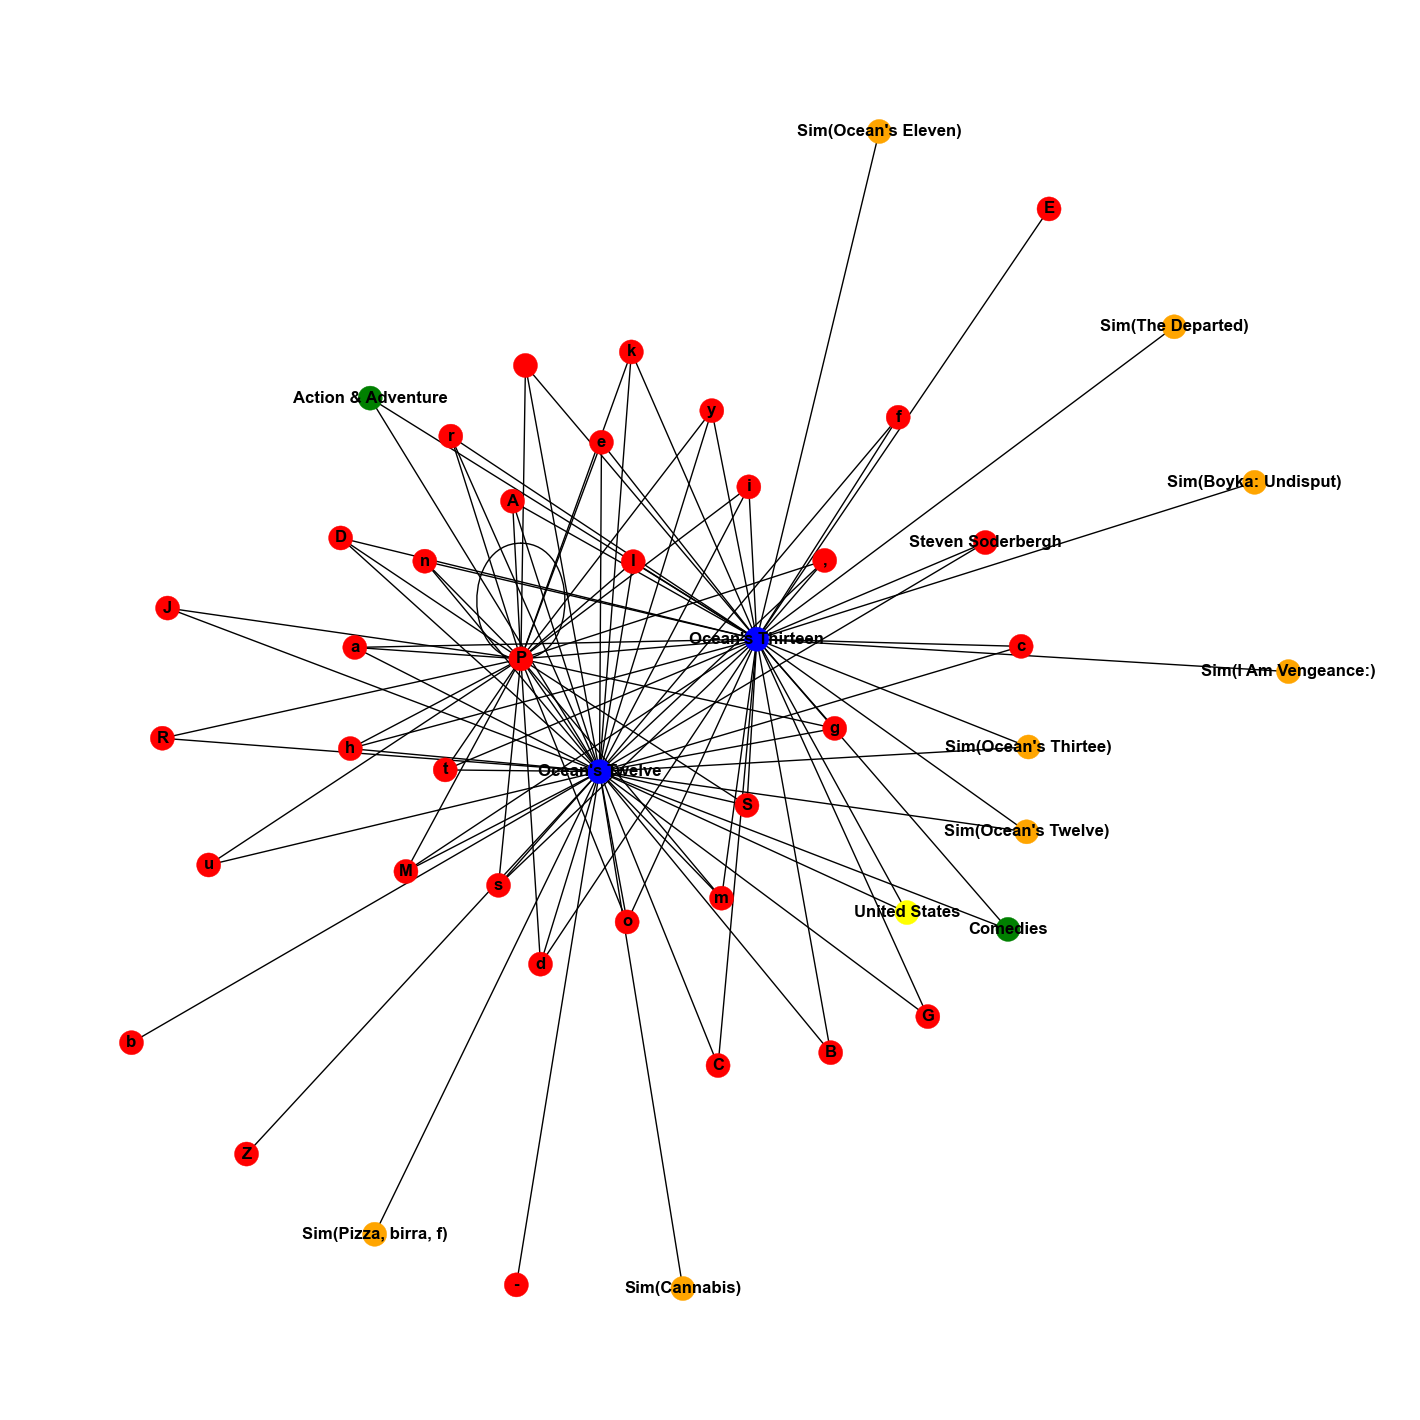

In [7]:
list_in = ["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = rd.get_all_graph_node(list_in)
rd.draw_sub_graph(sub_graph)

In [8]:
result = rd.get_recommendation("Ocean's Twelve")


In [9]:
result

Ocean's Thirteen                                       5.174245
Ocean's Eleven                                         4.618066
The Laundromat                                         4.474103
Pizza, birra, faso                                     4.190535
I Am Vengeance: Retaliation                            4.107416
                                                         ...   
Gringo: The Dangerous Life of John McAfee              0.123445
GLOW: The Story of the Gorgeous Ladies of Wrestling    0.123445
Girls Incarcerated                                     0.123445
One Take                                               0.120796
Virunga                                                0.112855
Length: 7454, dtype: float64

In [12]:
result1 = rd.get_recommendation("Ocean's Twelve")
result2 = rd.get_recommendation("Ocean's Thirteen")
result3 = rd.get_recommendation("Stranger Things")

print("*" * 50 +"\nRecommendation for Ocean's Twelve\n"+'*' * 50)
print(result1.head())
print("*" * 50 +"\nRecommendation for Ocean's Thirteen\n"+'*' * 50)
print(result2.head())
print("*" * 50 +"\nRecommendation for Stranger Things\n"+'*' * 50)
print(result3.head())

**************************************************
Recommendation for Ocean's Twelve
**************************************************
Ocean's Thirteen               5.174245
Ocean's Eleven                 4.618066
The Laundromat                 4.474103
Pizza, birra, faso             4.190535
I Am Vengeance: Retaliation    4.107416
dtype: float64
**************************************************
Recommendation for Ocean's Thirteen
**************************************************
Ocean's Twelve                 5.174245
Ocean's Eleven                 4.889634
I Am Vengeance: Retaliation    4.510621
The Departed                   4.458712
Boyka: Undisputed              4.228825
dtype: float64
**************************************************
Recommendation for Stranger Things
**************************************************
Big Stone Gap             6.849336
Rowdy Rathore             5.960861
Love, Death & Robots      5.510340
Beyond Stranger Things    5.496395
Lady Dynamite      

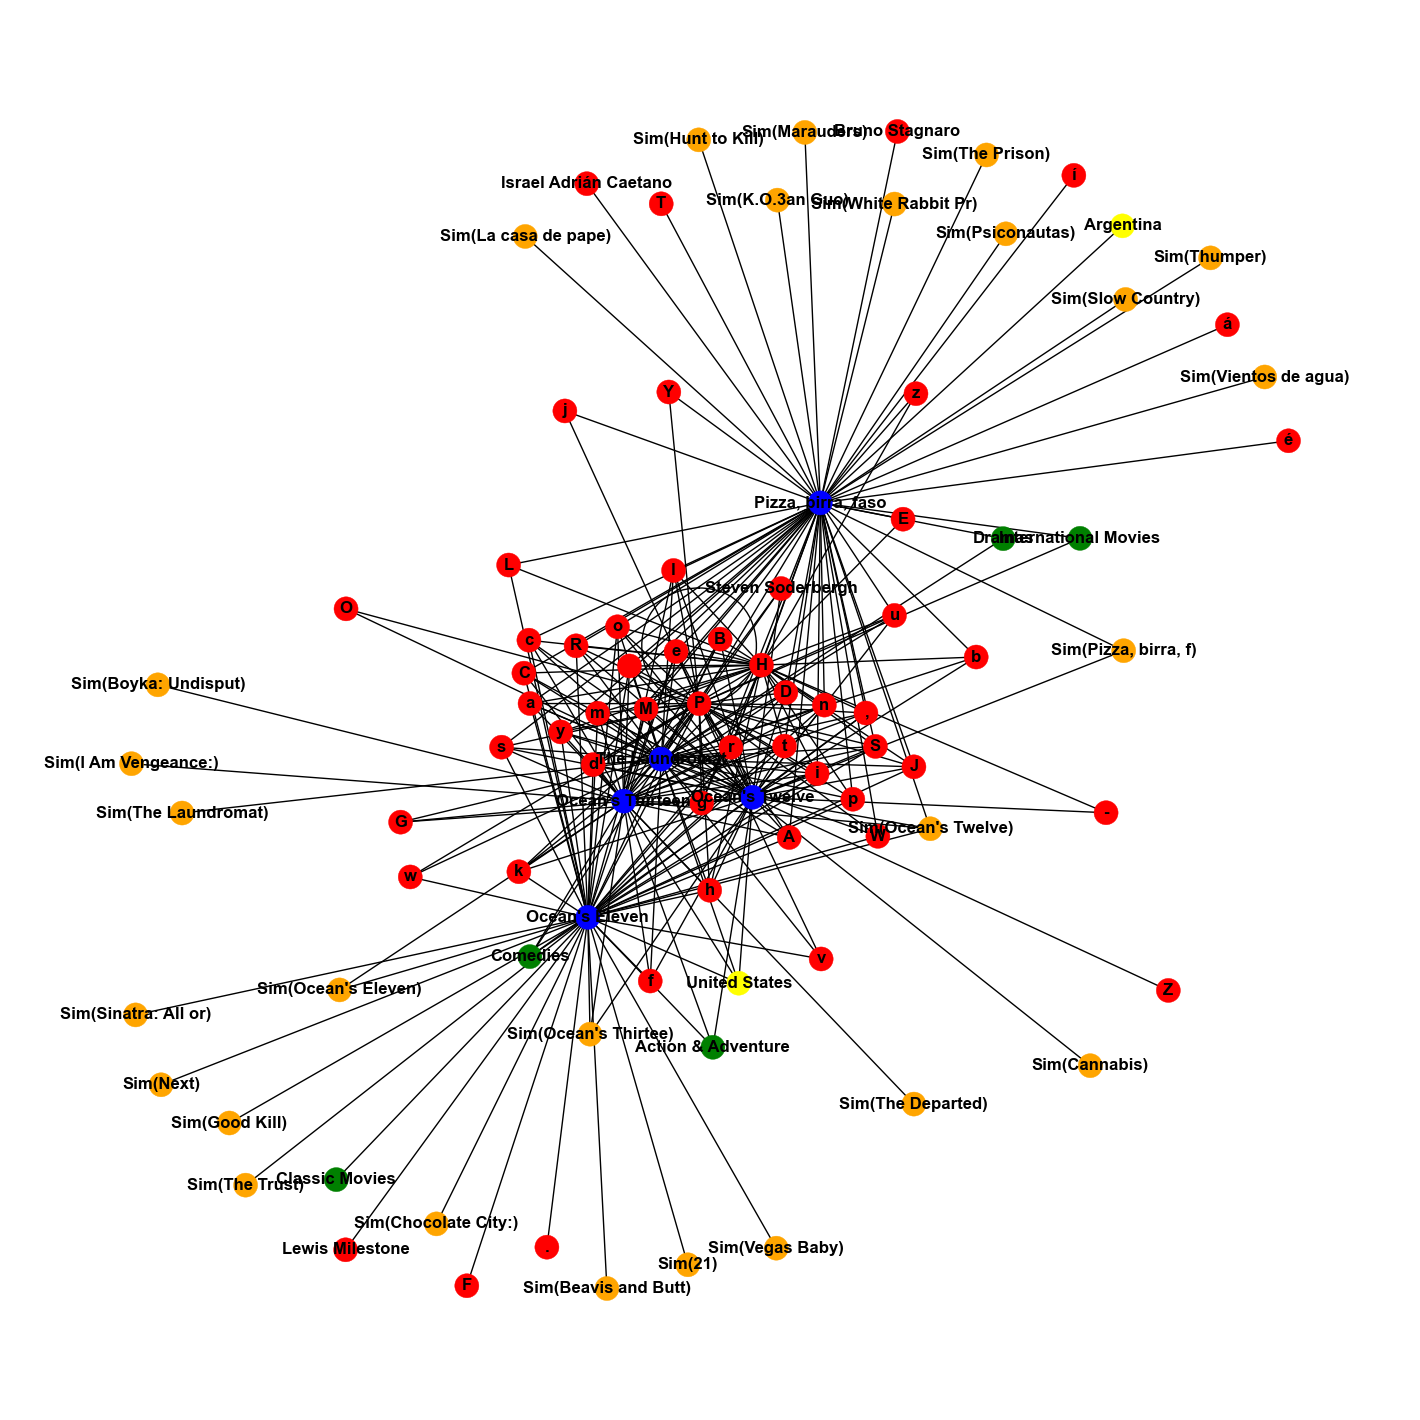

In [13]:
recom = list(result.index[:4].values)
recom.extend(["Ocean's Twelve"])
sub_graph = rd.get_all_graph_node(recom)
rd.draw_sub_graph(sub_graph)